# Анализ оттока клиентов банка

# 1. Подготовка данных

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
data = pd.read_csv('/datasets/Churn.csv')
data

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Датасет содержит информацию о десяти тысячах клиентах банка "Бета-Банк", включая их кредитный рейтинг, пол, страну проживания, баланс, количество недвижимости у клиента, факт ухода клиента и другое. На первый взгляд необходимо осуществить следующие корректировки в данных: удалить не нужные столбца с данными, которые могут негативно повлиять на построение модели, но сами по себе не несут особой значимости - RowNumber (порядковый номер), CustomerId (идентификатор клиента), Surname (фамилия клиента). 

Так же необходимо избавиться от пропусков в столбце Tenure (количество недвижимости у клиента), для этого заменим их на 0, предполагая, что если не указано количество недвижимости, то оно отсутствует и при заполнении профиля клиента данный параметр был не заполнен.

Следует также перевести вещественный тип данных столбцов в int, необходимый для исследования. Исходя из того, что данные разнятся в зависимости от названия столбца (что логично). необходимо признаки масштабировать, чтобы они находились в одной плоскости.

In [3]:
data['Tenure'] = data['Tenure'].fillna(0)
data.drop(['RowNumber', 'CustomerId', 'Surname'], axis='columns', inplace=True)
data = pd.get_dummies(data, drop_first=True)

data['Geography_Germany'] = data['Geography_Germany'].astype('int')
data['Geography_Spain'] = data['Geography_Spain'].astype('int')
data['Gender_Male'] = data['Gender_Male'].astype('int')

In [4]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
data_scaled = data

scaler = StandardScaler()
scaler.fit(data[numeric])
data[numeric] = scaler.transform(data[numeric])

In [5]:
data.head(5)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,-0.326221,0.293517,-0.817441,-1.225848,1,1,1,0.021886,1,0,0,0
1,-0.440036,0.198164,-1.138838,0.117350,1,0,1,0.216534,0,0,1,0
2,-1.536794,0.293517,1.110941,1.333053,3,1,0,0.240687,1,0,0,0
3,0.501521,0.007457,-1.138838,-1.225848,2,0,0,-0.108918,0,0,0,0
4,2.063884,0.388871,-0.817441,0.785728,1,1,1,-0.365276,0,0,1,0


Так выглядит таблица после преобразований, все данные числительные, столбцы указывающие на гендер и страну клиента преобразованы.

# 2. Исследование задачи

Разделим исходные данные на на выборки в следующем процентном соотношении:
* data_train - обучающая выборка (70%)
* data_test - тестовая выборка (15%)
* data_valid - валидационная аыборка (15%)

Использовали модель для деления 14:3:3 так как, помимо валидационной выборки выделяем так же тестовую выборку (равную ей) для дальнейшего тестирования поведения модели.

In [6]:
data_train, data_test_valid = train_test_split(data, test_size=0.3, random_state=12345)
data_test, data_valid = train_test_split(data_test_valid, test_size=0.5, random_state=12345)

Сохраненим признаки в отдельных переменных: features - все признаки, кроме целевого признака (факт ухода клиента из банка), target — целевой признак, столбец Exited (где 1 - клиент покинул банк, 0 - остался клиентом банка).

In [7]:
features_train = data_train.drop(columns=['Exited'], axis=1)
target_train = data_train['Exited']

features_valid = data_valid.drop(columns=['Exited'], axis=1)
target_valid = data_valid['Exited']

features_test = data_test.drop(columns=['Exited'], axis=1)
target_test = data_test['Exited']

Построим модель дерева решений. И найдем лучшее значение качества этой модели (accuracy).

In [8]:
for depth in range(1, 9):
    model = DecisionTreeClassifier(max_depth = depth, random_state=12345)
    model.fit(features_train, target_train)
    valid_predictions = model.predict(features_valid)
    valid_accuracy = accuracy_score(target_valid, valid_predictions)
    print("max_depth =", depth, "accuracy =", valid_accuracy)

max_depth = 1 accuracy = 0.7873333333333333
max_depth = 2 accuracy = 0.8173333333333334
max_depth = 3 accuracy = 0.8286666666666667
max_depth = 4 accuracy = 0.8333333333333334
max_depth = 5 accuracy = 0.844
max_depth = 6 accuracy = 0.8406666666666667
max_depth = 7 accuracy = 0.8413333333333334
max_depth = 8 accuracy = 0.834


При max_depth равному 5 мы будем иметь наилучшее качество модели.

In [9]:
model = DecisionTreeClassifier(random_state=12345, max_depth = 5)
model.fit(features_train, target_train)

valid_predictions = model.predict(features_valid)
valid_accuracy = accuracy_score(target_valid, valid_predictions)

print("Валидационная выборка:", valid_accuracy)

Валидационная выборка: 0.844


Проверка качества модели на валидационной модели дало результат примерно 0,844, что очень неплохой результат. Проведем проверку адекватности модели для этого проанализируем частоты классов в результатах предсказаний решающего дерева.

0    0.860667
1    0.139333
dtype: float64


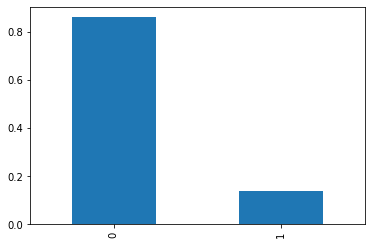

In [10]:
vp = pd.Series(valid_predictions)
class_frequency = vp.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')

Классы имеют очень большой разрыв в количестве значений, что наблюдается из графика. Необходимо сбалансировать классы.

In [11]:
print('F1-мера =', f1_score(target_valid, valid_predictions))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print('ROC-AUC-мера =', roc_auc_score(target_valid, probabilities_one_valid))

F1-мера = 0.5568181818181818
ROC-AUC-мера = 0.8453385500306578


Так как классы не сбалансированы для измерения точности и полноты предсказаний модели необходимо использовать среднегармонический параметр - f1-мера. Близкая к нулю f1-мера показывает, что прогноз класса 1 не удался.
ROC-AUC-мера усредняется по всем возможным порогам, в отличие от f1-меры, которая зависит от точности и полноты.
Сравнивая значения этих двух параметров стоит отметить, что наиболее важна при оценке несбалансированных данных f1-мера со значением 0,56.

Построим модель Случайного леса. Подберем такие значения гиперпараметров глубины и ширины деревьев, которые будут соответствовать наилучшему числу accurcy.

In [12]:
for estimator in range(10, 100, 20):
    for depth in range(1, 16, 2):
        model = RandomForestClassifier(n_estimators=estimator, max_depth=depth, random_state=12345)
        model.fit(features_train, target_train)
        valid_predictions = model.predict(features_valid)
        valid_accuracy = accuracy_score(target_valid, valid_predictions)
        print("n_estimators =", estimator, "max_depth =", depth, "accuracy =", valid_accuracy)

n_estimators = 10 max_depth = 1 accuracy = 0.7873333333333333
n_estimators = 10 max_depth = 3 accuracy = 0.8066666666666666
n_estimators = 10 max_depth = 5 accuracy = 0.8386666666666667
n_estimators = 10 max_depth = 7 accuracy = 0.8433333333333334
n_estimators = 10 max_depth = 9 accuracy = 0.8413333333333334
n_estimators = 10 max_depth = 11 accuracy = 0.8466666666666667
n_estimators = 10 max_depth = 13 accuracy = 0.8393333333333334
n_estimators = 10 max_depth = 15 accuracy = 0.8346666666666667
n_estimators = 30 max_depth = 1 accuracy = 0.7873333333333333
n_estimators = 30 max_depth = 3 accuracy = 0.806
n_estimators = 30 max_depth = 5 accuracy = 0.8346666666666667
n_estimators = 30 max_depth = 7 accuracy = 0.8426666666666667
n_estimators = 30 max_depth = 9 accuracy = 0.8466666666666667
n_estimators = 30 max_depth = 11 accuracy = 0.8433333333333334
n_estimators = 30 max_depth = 13 accuracy = 0.838
n_estimators = 30 max_depth = 15 accuracy = 0.8413333333333334
n_estimators = 50 max_depth 

Наилучшим сочетанием гиперпараметров является:

n_estimators = 70 max_depth = 15 accuracy = 0.8473333333333334

Его и будем использовать для проверки модели.

In [13]:
model = RandomForestClassifier(random_state=12345, n_estimators=70, max_depth = 15)
model.fit(features_train, target_train)

valid_predictions = model.predict(features_valid)
valid_accuracy = accuracy_score(target_valid, valid_predictions)

print("Валидационная выборка:", valid_accuracy)

Валидационная выборка: 0.8473333333333334


Проверка качества модели на валидационной модели дало результат примерно 0,847, что, в принципе соответствует желаемому. Посмотрим значения f1-меры и roc_auc. 

In [14]:
print('F1-мера = ', f1_score(target_valid, valid_predictions))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print('ROC-AUC-мера = ', roc_auc_score(target_valid, probabilities_one_valid))

F1-мера =  0.5465346534653466
ROC-AUC-мера =  0.8509246454441934


Опять же значение f1-меры гораздо меньше roc_auc параметра. При несбалансированных данных f1-мера наиболее актуальна. roc_auc говорит о данных максимально качесвенной модели. В сравнении с значениями этих праметров решающего дерева f1-мера уменьшилась, тогда как roc_auc-мера увеличилась.

Посчитаем дисбаланс классов:

0    0.7963
1    0.2037
Name: Exited, dtype: float64


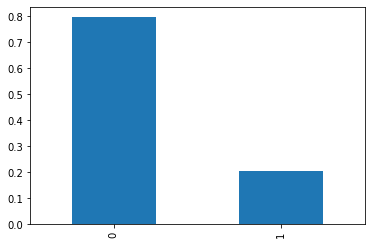

In [15]:
vp = data['Exited']
class_frequency = vp.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')

Выше приведен график соотношения классов по всем данным столбца Exited всего датасета. Так 0-значений гораздо больше, чем 1-значений.

Ниже график соотношения классов на валидационной выборке.

0    0.876
1    0.124
dtype: float64


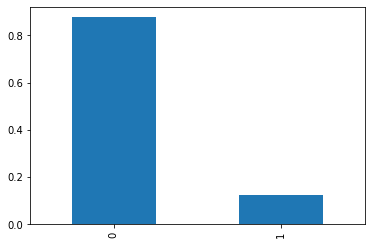

In [232]:
vp = pd.Series(valid_predictions)
class_frequency = vp.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')

In [233]:
target_pred_constant = pd.Series(0, index=target_train.index)

print(accuracy_score(target_train, target_pred_constant))

0.7984285714285714


Посмотрев на accuracy константной модели можно сказать, что она не сильно отличается от accuracy моделей решающего дерева и случайного леса. Этот факт так же свидетельствует о том, что наблюдается дисбаланс классов.

# 3. Борьба с дисбалансом

Борьба с дисбалансом модели решающего дерева.

Применим гиперпараметр, при расчете который делает данные для модели сбалансированными.

In [16]:
model_cwb_DTC = DecisionTreeClassifier(random_state=12345, max_depth = 5, class_weight='balanced')
model_cwb_DTC.fit(features_train, target_train)

valid_predictions = model_cwb_DTC.predict(features_valid)
print('F1-мера = ', f1_score(target_valid, valid_predictions))

probabilities_valid = model_cwb_DTC.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print('ROC-AUC-мера = ', roc_auc_score(target_valid, probabilities_one_valid))

F1-мера =  0.5784447476125513
ROC-AUC-мера =  0.8358080793334378


После балансировки можем наблюдать увеличение значения f1-меры и уменьшение roc_auc-меры. Но в целом, при проверке на валидационной выборке f1-мера не достигает целевого показателя в 0,59.

Попробуем использовать метод upsampling для уменьшения дисбаланса классов, увеличив выборку в 3 раза (дает наиболее оптимальное значение f1-меры при подборе):

In [17]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target_train[target_train == 0]
    target_ones = target_train[target_train == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    return features_upsampled, target_upsampled
    
features_upsampled, target_upsampled = upsample(features_train, target_train, 3)
model_ups_DTC = DecisionTreeClassifier(random_state=12345, max_depth = 5)
model_ups_DTC.fit(features_upsampled, target_upsampled)

valid_predictions = model_ups_DTC.predict(features_valid)
print('F1-мера = ', f1_score(target_valid, valid_predictions))

probabilities_valid = model_ups_DTC.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print('ROC-AUC-мера = ', roc_auc_score(target_valid, probabilities_one_valid))

F1-мера =  0.6011730205278594
ROC-AUC-мера =  0.8358080793334378


Удалось еще больше увеличить значение f1-меры. Так же можем констатировать взаимосвязь между f1 и roc_auc - чем выше f1, тем меньше становится значение roc_auc-меры.

Повторим манипуляции с моделью Случайного леса:

In [18]:
model_cwb_RFC = RandomForestClassifier(random_state=12345, n_estimators = 70, max_depth = 15, class_weight='balanced')
model_cwb_RFC.fit(features_train, target_train)

valid_predictions = model_cwb_RFC.predict(features_valid)
print('F1-мера = ', f1_score(target_valid, valid_predictions))

probabilities_valid = model_cwb_RFC.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print('ROC-AUC-мера = ', roc_auc_score(target_valid, probabilities_one_valid))

F1-мера =  0.5390625000000001
ROC-AUC-мера =  0.8496014482174661


Балансировка подобным методом снизила f1-меру по отношению к несбалансированной, что еще больше отдалило от целевого значения в 0,59. Попробуем применить upsampeling.

In [19]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target_train[target_train == 0]
    target_ones = target_train[target_train == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    return features_upsampled, target_upsampled
    
features_upsampled, target_upsampled = upsample(features_train, target_train, 3)

model_ups_RFC = RandomForestClassifier(random_state=12345, n_estimators = 70, max_depth = 15)
model_ups_RFC.fit(features_upsampled, target_upsampled)

valid_predictions = model_ups_RFC.predict(features_valid)
print('F1-мера = ', f1_score(target_valid, valid_predictions))

probabilities_valid = model_ups_RFC.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print('ROC-AUC-мера = ', roc_auc_score(target_valid, probabilities_one_valid))

F1-мера =  0.5980066445182723
ROC-AUC-мера =  0.8464693063367477


Данное преобразование позволило достичь f1 выше целевого значения. 

Найдем тестовые показатели этих двух мер на всех моделях на тестовой выборке.

# 4. Тестирование модели

In [20]:
predicted_test = model_cwb_DTC.predict(features_test)
print('F1-мера = ', f1_score(target_test, predicted_test))

probabilities_test = model_ups_RFC.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
print('ROC-AUC-мера = ', roc_auc_score(target_test, probabilities_one_test))

F1-мера =  0.5933147632311978
ROC-AUC-мера =  0.8467034902293781


In [21]:
predicted_test = model_ups_DTC.predict(features_test)
print('F1-мера = ', f1_score(target_test, predicted_test))

probabilities_test = model_ups_RFC.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
print('ROC-AUC-мера = ', roc_auc_score(target_test, probabilities_one_test))

F1-мера =  0.6024096385542168
ROC-AUC-мера =  0.8467034902293781


In [22]:
predicted_test = model_cwb_RFC.predict(features_test)
print('F1-мера = ', f1_score(target_test, predicted_test))

probabilities_test = model_ups_RFC.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
print('ROC-AUC-мера = ', roc_auc_score(target_test, probabilities_one_test))

F1-мера =  0.5956607495069033
ROC-AUC-мера =  0.8467034902293781


In [23]:
predicted_test = model_ups_RFC.predict(features_test)
print('F1-мера = ', f1_score(target_test, predicted_test))

probabilities_test = model_ups_RFC.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
print('ROC-AUC-мера = ', roc_auc_score(target_test, probabilities_one_test))

F1-мера =  0.600349040139616
ROC-AUC-мера =  0.8467034902293781


Все модели достигли челевого показателя f1-меры обозначенного в 0,59 на тестовой выборке. Значение показателя roc_auc является неизменным для всех моделей, так как он строится на одинаковых данных, учитывая все пороговые значения.

### Общий вывод

В результате проекта, были загружены и подготовлены для дальнейшего анализа данные. Перед нами стояла задача повысить значение f1-меры и посмотреть как зависит от нее значение roc-auc-меры. Были исследованы модели решающего дерева и случайного леса без учета дисбаланса классов и с их учетом. 

В ходе обучения моделей наилучшей в своем поведении можно признать модель решающего дерева сбалансированную методом апсемплинга, проверенную на тестовой выборке, получены значения f1-меры - 0,6, и roc-auc-меры 0,85. Что касаемо взаиосвязи f1-меры и roc_auc-меры, чем меньше первая, тем больше вторая, и наоборот. При дисбалансе классов необходимо опираться на f1-меру. 